In [10]:
import importlib
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/decumulation/misc.py'>

In [11]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

In [12]:
# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

In [13]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

In [14]:
# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [15]:
class FixedPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12

    def get_scenario(self, rt, init_val, contri, withdr):
        except_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(except_ret)
        val += contri
        val -= withdr
        return val
    
    def run(self, rets, init_rt, init_val, contribution, withdrawal, const):
        n = rets.shape[0] + 1
        m = rets.shape[1]
        current_idx = 0
        end_idx = n - 1

        rt = init_rt
        contributions = contribution * np.ones(n)
        withdrawals = withdrawal * np.ones(n)
        total_withdrawal = 0

        S = np.zeros(n)
        S[current_idx] = init_val
        w = np.zeros((n, m))
        w[current_idx] = self.weights[rt]
        x = np.zeros((n, m))
        x[current_idx] = self.weights[rt] * (init_val + contributions[current_idx])
        scenario = np.zeros(n)
        scenario[current_idx] = init_val
        record_withdrawals = np.zeros(n)
        record_withdrawals[current_idx] = 0
        while True:
            current_idx += 1
            withdrawal_const = 1 if const else (S[current_idx-1] / scenario[current_idx-1] if scenario[current_idx-1] != 0 else 1.0)
            scenario[current_idx] = self.get_scenario(rt, scenario[current_idx-1], contributions[current_idx-1], withdrawals[current_idx-1])
            S[current_idx] = np.dot(1 + rets[current_idx-1], x[current_idx-1])
            S[current_idx] += contributions[current_idx]
            current_withdrawal = (withdrawals[current_idx] * withdrawal_const) if S[current_idx] >= (withdrawals[current_idx] * withdrawal_const) else S[current_idx]
            S[current_idx] -= current_withdrawal
            total_withdrawal -= current_withdrawal
            record_withdrawals[current_idx] = current_withdrawal

            if np.abs(np.sum(w[current_idx-1] - self.weights[rt])) > 0:
                x[current_idx] = S[current_idx] * self.weights[rt]
            else:
                x[current_idx] = x[current_idx-1] * (1 + rets[current_idx-1])
                x[current_idx] += (contributions[current_idx] * self.weights[rt])
                x_withdrawal = (withdrawals[current_idx]* self.weights[rt]) * withdrawal_const
                x_withdrawal = x_withdrawal if np.sum(x[current_idx]) >= np.sum(x_withdrawal) else x[current_idx]
                x[current_idx] -= x_withdrawal
            
            if S[current_idx] > 0:
                w[current_idx] = x[current_idx] / S[current_idx]
            else:
                w[current_idx] = 0

            if current_idx == end_idx:
                break
            
        self.scenario = scenario
        self.record_withdrawals = record_withdrawals
        self.total_withdrawal = total_withdrawal
        return S, x, w

In [36]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 3
N_STEPS = 12 * 35 # month
N_PATHS = 10
AGE = np.arange(65, 100+1/12, 1/12)

rets = bootstrap(df_returns, n_steps=N_STEPS)

In [37]:
base = FixedPortfolio(weights)

In [38]:
scenario = np.zeros(N_STEPS + 1)
scenario[0] = INIT_VAL
for t in range(1, N_STEPS+1):
    scenario[t] = base.get_scenario(RT, scenario[t-1], 0, WITHDRAWAL_RATE*INIT_VAL)
scenario_T = scenario[-1]

In [39]:
def expected_terminal_under_RT_cf(mu_rt, sigma_rt, dt, W0, steps_left, contrib, withdr):
    A = exp((mu_rt - 0.5*(sigma_rt**2)) * dt)
    C = (contrib - withdr)
    if abs(A - 1.0) < 1e-12:
        return W0 + steps_left * C
    A_n = A**steps_left
    return W0 * A_n + C * (A_n - 1.0) / (A - 1.0)

def choose_rt_scenario_downside_fast(weights_df, base, t_years, steps_left, W0, scenario_T, contrib, withdr, alpha=1.0, beta=1.0):
    mu = weights_df["E[r]"].to_numpy()
    sigma = weights_df["Vol"].to_numpy()
    dt = 1.0/12.0
    denom = max(scenario_T, 1e-9)
    scores, zs, devs = [], [], []
    for rt in range(len(weights_df)):
        # z-score for probability term
        if sigma[rt] <= 0:
            req_mu = (np.log(scenario_T/W0)/t_years) if (W0>0 and scenario_T>0 and t_years>0) else -np.inf
            z = np.inf if mu[rt] >= req_mu else -np.inf
        else:
            z = (((mu[rt] - 0.5*sigma[rt]**2) * np.sqrt(t_years)) - (np.log(scenario_T / W0) / np.sqrt(t_years))) / sigma[rt]
        # closed-form expected terminal
        EWT = expected_terminal_under_RT_cf(mu[rt], sigma[rt], dt, W0, steps_left, contrib, withdr)
        dev_down = max(scenario_T - EWT, 0.0) / denom
        score = alpha * z - beta * dev_down
        scores.append(score); zs.append(z); devs.append(dev_down)
    pick = int(np.argmax(scores))
    return pick, scores, zs, devs

def run_dynamic_rt_scenario_downside_fast(rets, weights_df, init_rt, init_val, contribution, withdrawal, init_age, terminal_age, alpha, beta):
    n = rets.shape[0] + 1
    m = rets.shape[1]
    base = FixedPortfolio(weights_df)
    # Scenario with init_rt
    scenario = np.zeros(n); scenario[0] = init_val
    for t in range(1, n):
        scenario[t] = base.get_scenario(init_rt, scenario[t-1], contribution, withdrawal)
    scenario_T = float(scenario[-1])

    S = np.zeros(n); S[0] = init_val
    x = np.zeros((n, m)); x[0] = base.weights[init_rt] * (init_val + contribution)
    RTs = np.zeros(n, dtype=int); RTs[0] = init_rt
    ages = init_age + np.arange(n)/12.0
    record_withdrawals = np.zeros(n)
    record_withdrawals[0] = 0
    for t in range(1, n):
        t_years = max(terminal_age - ages[t-1], 1e-6)
        steps_left = n - t
        pick, *_ = choose_rt_scenario_downside_fast(weights_df, base, t_years, steps_left, S[t-1], scenario_T, contribution, withdrawal, alpha, beta)
        RTs[t] = pick
        # wealth update
        S[t] = np.dot(1.0 + rets[t-1], x[t-1]) + contribution
        wd = min(withdrawal, S[t])
        S[t] -= wd
        x[t] = S[t] * base.weights[pick]
        record_withdrawals[t] = wd
    return S, RTs, scenario, record_withdrawals

In [40]:
S, RTs, scenario_path, record_withdrawals = run_dynamic_rt_scenario_downside_fast(
    rets, 
    weights, 
    RT, 
    INIT_VAL, 
    0,
    WITHDRAWAL_RATE*INIT_VAL,
    65, 
    100, 
    0.5, 0.5
)

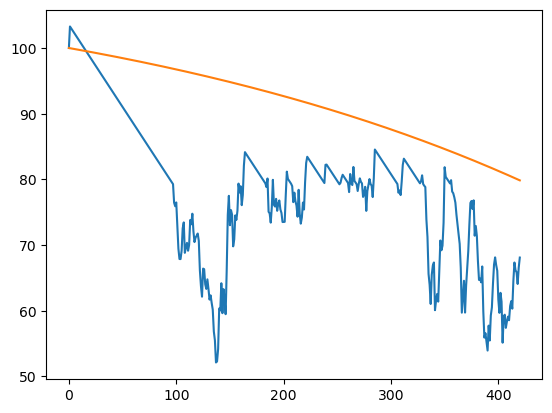

In [41]:
plt.plot(S)
plt.plot(scenario_path)
plt.show()

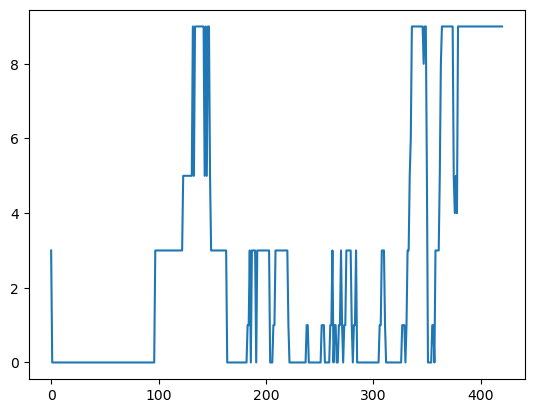

In [42]:
plt.plot(RTs)
plt.show()

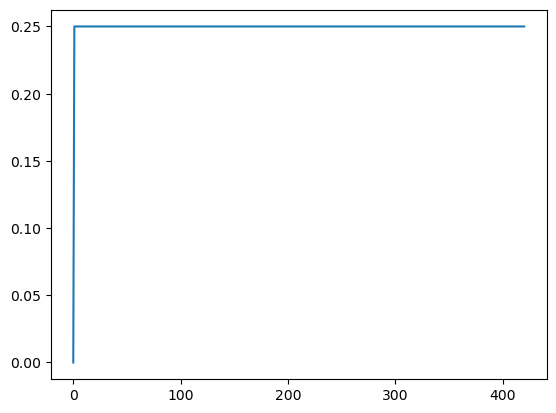

In [43]:
plt.plot(record_withdrawals)
plt.show()

In [44]:
# --- Policy heatmap (fast) ---
years_grid = np.linspace(2, 35, 18)
ratio_grid = np.linspace(0.7, 1.3, 25)
policy = np.zeros((len(ratio_grid), len(years_grid)), dtype=int)

alpha_sel, beta_sel = 1, 1

for j, t_years in enumerate(years_grid):
    steps_left = int(round(t_years * 12))
    scen_idx = max(0, len(scenario) - steps_left - 1)
    S_ref = scenario[scen_idx]
    for i, r in enumerate(ratio_grid):
        W0 = r * S_ref
        pick, *_ = choose_rt_scenario_downside_fast(
            weights, base, t_years, steps_left, W0, scenario_T,
            0, WITHDRAWAL_RATE*INIT_VAL, alpha_sel, beta_sel
        )
        policy[i, j] = pick

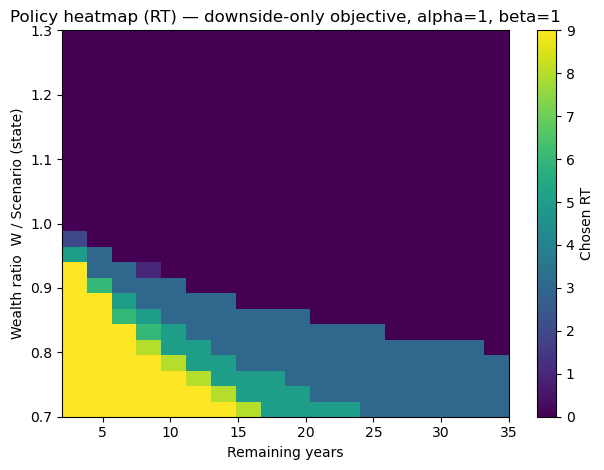

In [45]:
plt.figure()
plt.imshow(policy, aspect='auto', origin='lower',
           extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]])
plt.colorbar(label="Chosen RT")
plt.xlabel("Remaining years")
plt.ylabel("Wealth ratio  W / Scenario (state)")
plt.title("Policy heatmap (RT) — downside-only objective, alpha=1, beta=1")
plt.tight_layout()
plt.show()

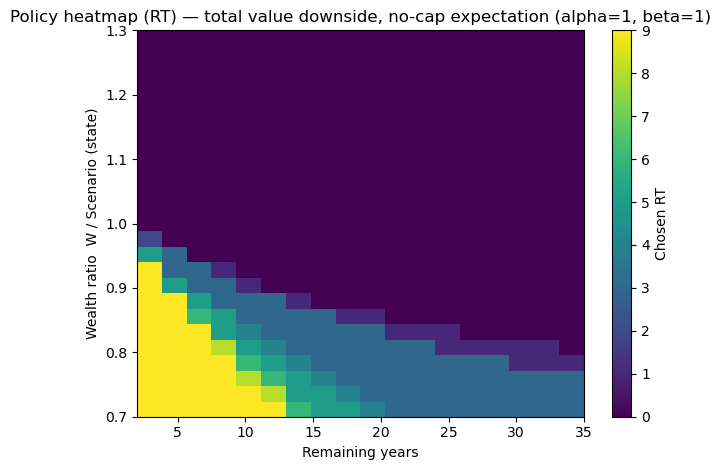

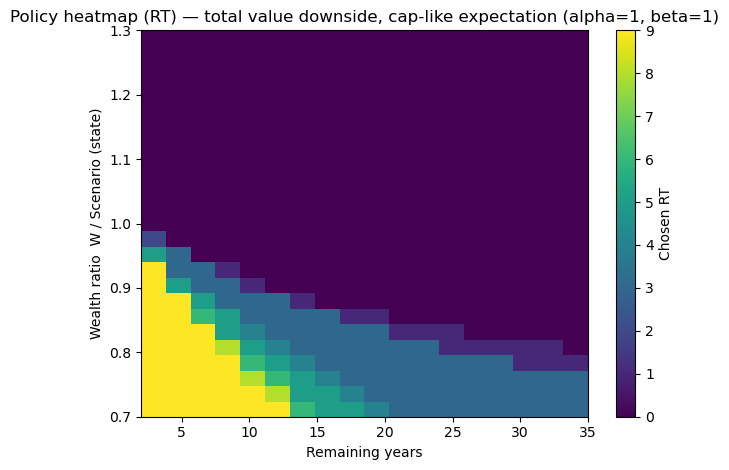

In [48]:
# Policy heatmap for the "total value" downside-only controller
# (1) no-cap expectation (fast) and (2) cap-like expectation (min(withdrawal, wealth) per step)
# Base program is preserved; this only computes the policy map over state grid.
#
# Axes:
# - x: remaining years (2..35)
# - y: state ratio r = W / Scenario_state  (0.7..1.3)
# Value: chosen RT (0..9)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Ensure environment ----
from math import exp

# Recreate essentials if missing
if 'weights' not in globals() or 'df_returns' not in globals():
    mu_assets = {
        "asset0": 1.43*1e-02, "asset1": 5.19*1e-02, "asset2": 3.46*1e-02,
        "asset3": 0.86*1e-02, "asset4": 5.95*1e-02, "asset5": 2.67*1e-02,
        "asset6": 5.84*1e-02, "asset7": 7.28*1e-02, "asset8": 0,
    }
    sig_assets = {
        "asset0": np.sqrt(2.36*1e-02), "asset1": np.sqrt(14.60*1e-02), "asset2": np.sqrt(7.48*1e-02),
        "asset3": np.sqrt(4.75*1e-02), "asset4": np.sqrt(17.13*1e-02), "asset5": np.sqrt(14.45*1e-02),
        "asset6": np.sqrt(14.46*1e-02), "asset7": np.sqrt(18.99*1e-02), "asset8": 0,
    }
    weights = pd.DataFrame()
    weights["RT"] = np.arange(0, 10, 1)
    weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
    weights["E[r]"] = [0, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
    weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
    weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
    weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
    weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
    weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
    weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
    weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
    weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
    weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", seed=123):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    P = 12
    mu_p = np.array([mu_dict[a] / P for a in assets])
    sig_p = np.array([sig_dict[a] / np.sqrt(P) for a in assets])
    D = np.diag(sig_p)
    cov = D @ np.eye(n) @ D
    shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
    rets = shocks + mu_p
    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    return pd.DataFrame(rets, index=idx, columns=assets)

if 'df_returns' not in globals():
    df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", seed=123)

# Base class
class FixedPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12
    def get_scenario(self, rt, init_val, contri, withdr):
        expect_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(expect_ret)
        val += contri
        val -= withdr
        return val

# z-score for scenario target
from math import log, sqrt
def z_goal(mu, sigma, t_years, W0, WT):
    if sigma <= 0:
        req_mu = (log(WT/W0)/t_years) if (W0>0 and WT>0 and t_years>0) else -np.inf
        return np.inf if mu >= req_mu else -np.inf
    return (((mu - 0.5*sigma**2) * sqrt(t_years)) - (log(WT / W0) / sqrt(t_years))) / sigma

# Closed-form expected terminal
def expected_terminal_under_RT_cf(mu_rt, sigma_rt, dt, W0, steps_left, contrib, withdr):
    A = np.exp((mu_rt - 0.5*(sigma_rt**2)) * dt)
    C = (contrib - withdr)
    if abs(A - 1.0) < 1e-12:
        return W0 + steps_left * C
    A_n = A**steps_left
    return W0 * A_n + C * (A_n - 1.0) / (A - 1.0)

# cap-like deterministic projection (min(withdrawal, wealth))
def det_project_with_caps(base: FixedPortfolio, rt: int, W0: float, steps_left: int, contrib: float, withdr: float):
    val = W0
    cum_w = 0.0
    for _ in range(steps_left):
        expect_ret = (base.mu[rt] - 0.5 * np.power(base.sigma[rt], 2)) * base.dt
        pre = val * np.exp(expect_ret) + contrib
        wd = min(withdr, pre)
        val = pre - wd
        cum_w += wd
    return val, cum_w

def choose_rt_total_downside(weights_df, base: FixedPortfolio, t_years, steps_left, W0, scenario_T, scenario_rem_cum_wd, contrib, withdr, alpha=1.0, beta=1.0, use_caps=False):
    mu = weights_df["E[r]"].to_numpy()
    sigma = weights_df["Vol"].to_numpy()
    dt = 1.0/12.0
    scores, zs, devs = [], [], []
    denom = max(scenario_T + scenario_rem_cum_wd, 1e-9)
    for rt in range(len(weights_df)):
        z = z_goal(mu[rt], sigma[rt], t_years, W0, scenario_T)
        if use_caps:
            EWT, ER_cum_wd = det_project_with_caps(base, rt, W0, steps_left, contrib, withdr)
        else:
            EWT = expected_terminal_under_RT_cf(mu[rt], sigma[rt], dt, W0, steps_left, contrib, withdr)
            ER_cum_wd = steps_left * withdr
        total_RT = EWT + ER_cum_wd
        total_scn = scenario_T + scenario_rem_cum_wd
        dev_down = max(total_scn - total_RT, 0.0) / denom
        score = 1.0 * z - 1.0 * dev_down  # alpha=1, beta=1 by default
        scores.append(score); zs.append(z); devs.append(dev_down)
    pick = int(np.argmax(scores))
    return pick

# --- Build baseline scenario (RT=3) ---
INIT_RT = 3
INIT_VAL = 100.0
WITHDRAWAL = 0.03/12 * INIT_VAL
CONTRIB = 0.0
N_STEPS = 12*35

base = FixedPortfolio(weights)
scenario = np.zeros(N_STEPS+1); scenario[0] = INIT_VAL
for t in range(1, N_STEPS+1):
    scenario[t] = base.get_scenario(INIT_RT, scenario[t-1], CONTRIB, WITHDRAWAL)
scenario_T = float(scenario[-1])

# --- Policy heatmaps ---
years_grid = np.linspace(2, 35, 18)   # 2..35 years remaining
ratio_grid = np.linspace(0.7, 1.3, 25)  # W / Scenario state

def compute_policy(use_caps: bool):
    policy = np.zeros((len(ratio_grid), len(years_grid)), dtype=int)
    for j, t_years in enumerate(years_grid):
        steps_left = int(round(t_years * 12))
        scen_idx = max(0, len(scenario) - steps_left - 1)
        S_ref = scenario[scen_idx]
        scenario_rem_cum_wd = steps_left * WITHDRAWAL
        for i, r in enumerate(ratio_grid):
            W0 = r * S_ref
            rt = choose_rt_total_downside(
                weights, base, t_years, steps_left, W0, scenario_T, scenario_rem_cum_wd,
                CONTRIB, WITHDRAWAL, alpha=1.0, beta=1.0, use_caps=use_caps
            )
            policy[i, j] = rt
    return policy

# (1) no-cap expectation
policy_nocap = compute_policy(use_caps=False)
plt.figure()
plt.imshow(policy_nocap, aspect='auto', origin='lower',
           extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]])
plt.colorbar(label="Chosen RT")
plt.xlabel("Remaining years")
plt.ylabel("Wealth ratio  W / Scenario (state)")
plt.title("Policy heatmap (RT) — total value downside, no-cap expectation (alpha=1, beta=1)")
plt.tight_layout()
#heatmap_nocap_path = "/mnt/data/policy_heatmap_total_nocap.png"
plt.show()

# (2) cap-like expectation
policy_cap = compute_policy(use_caps=True)
plt.figure()
plt.imshow(policy_cap, aspect='auto', origin='lower',
           extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]])
plt.colorbar(label="Chosen RT")
plt.xlabel("Remaining years")
plt.ylabel("Wealth ratio  W / Scenario (state)")
plt.title("Policy heatmap (RT) — total value downside, cap-like expectation (alpha=1, beta=1)")
plt.tight_layout()
#heatmap_cap_path = "/mnt/data/policy_heatmap_total_cap.png"
plt.show()

# Save raw policies as CSV for inspection
policy_nocap_df = pd.DataFrame(policy_nocap, index=np.round(ratio_grid,3), columns=np.round(years_grid,2))
policy_cap_df = pd.DataFrame(policy_cap, index=np.round(ratio_grid,3), columns=np.round(years_grid,2))
#policy_nocap_csv = "/mnt/data/policy_total_nocap_table.csv"
#policy_cap_csv = "/mnt/data/policy_total_cap_table.csv"
#policy_nocap_df.to_csv(policy_nocap_csv)
#policy_cap_df.to_csv(policy_cap_csv)

#(heatmap_nocap_path, heatmap_cap_path, policy_nocap_csv, policy_cap_csv)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/policy_heatmap_scaled_nocap.png'

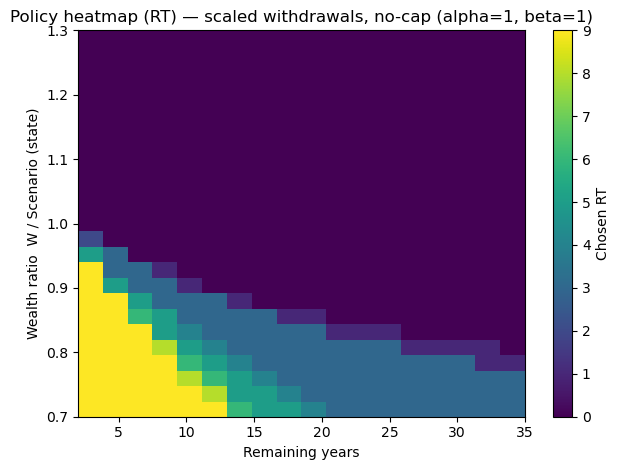

In [49]:
# Policy heatmaps for dynamic RT + scaled withdrawals (withdrawal_const=False)
# Total-value downside objective; compare:
#   (1) no-cap expectation   (2) cap-like expectation (min(wd, pre) each step)
#
# Axes:
#   x = remaining years (2..35)
#   y = state ratio r = W / Scenario_state  (0.7..1.3)
# Value: chosen RT (0..9)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, log, sqrt

# ---------- Recreate minimal environment if needed ----------
if 'weights' not in globals() or 'df_returns' not in globals():
    mu_assets = {
        "asset0": 1.43*1e-02, "asset1": 5.19*1e-02, "asset2": 3.46*1e-02,
        "asset3": 0.86*1e-02, "asset4": 5.95*1e-02, "asset5": 2.67*1e-02,
        "asset6": 5.84*1e-02, "asset7": 7.28*1e-02, "asset8": 0,
    }
    sig_assets = {
        "asset0": np.sqrt(2.36*1e-02), "asset1": np.sqrt(14.60*1e-02), "asset2": np.sqrt(7.48*1e-02),
        "asset3": np.sqrt(4.75*1e-02), "asset4": np.sqrt(17.13*1e-02), "asset5": np.sqrt(14.45*1e-02),
        "asset6": np.sqrt(14.46*1e-02), "asset7": np.sqrt(18.99*1e-02), "asset8": 0,
    }
    weights = pd.DataFrame()
    weights["RT"] = np.arange(0, 10, 1)
    weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
    weights["E[r]"] = [0, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
    weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
    weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
    weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
    weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
    weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
    weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
    weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
    weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
    weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

    def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", seed=123):
        rng = np.random.default_rng(seed)
        assets = list(mu_dict.keys())
        n = len(assets)
        P = 12
        mu_p = np.array([mu_dict[a] / P for a in assets])
        sig_p = np.array([sig_dict[a] / np.sqrt(P) for a in assets])
        D = np.diag(sig_p)
        cov = D @ np.eye(n) @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
        idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
        return pd.DataFrame(rets, index=idx, columns=assets)
    df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", seed=123)

class FixedPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12
    def get_scenario(self, rt, init_val, contri, withdr):
        expect_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(expect_ret)
        val += contri
        val -= withdr
        return val

def z_goal(mu, sigma, t_years, W0, WT):
    if sigma <= 0:
        req_mu = (np.log(WT/W0)/t_years) if (W0>0 and WT>0 and t_years>0) else -np.inf
        return np.inf if mu >= req_mu else -np.inf
    return (((mu - 0.5*sigma**2) * np.sqrt(t_years)) - (np.log(WT / W0) / np.sqrt(t_years))) / sigma

def expected_terminal_scaled_det(base: FixedPortfolio, rt: int, W0: float, steps_left: int,
                                 contrib: float, withdr: float,
                                 scenario_prefix: np.ndarray, cap_like: bool):
    V = W0
    cum_w = 0.0
    A = np.exp((base.mu[rt] - 0.5*(base.sigma[rt]**2)) * base.dt)
    for k in range(steps_left):
        S_scn_prev = scenario_prefix[k]
        k_t = withdr / max(S_scn_prev, 1e-9)
        pre = V * A + contrib
        wd = k_t * V
        if cap_like:
            wd = min(wd, pre)
        V = pre - wd
        cum_w += wd
    return V, cum_w

def choose_rt_total_downside_scaled(weights_df, base: FixedPortfolio, t_years, steps_left, W0,
                                    scenario_T, scenario_rem_cum_wd, scenario_rem_prefix,
                                    contrib, withdr, alpha=1.0, beta=1.0, cap_like=False):
    mu = weights_df["E[r]"].to_numpy()
    sigma = weights_df["Vol"].to_numpy()
    denom = max(scenario_T + scenario_rem_cum_wd, 1e-9)
    best_score, best_rt = -1e308, 0
    for rt in range(len(weights_df)):
        # z toward Scenario_T
        if sigma[rt] <= 0:
            req_mu = (np.log(scenario_T/W0)/t_years) if (W0>0 and scenario_T>0 and t_years>0) else -np.inf
            z = np.inf if mu[rt] >= req_mu else -np.inf
        else:
            z = (((mu[rt] - 0.5*sigma[rt]**2) * np.sqrt(t_years)) - (np.log(scenario_T / W0) / np.sqrt(t_years))) / sigma[rt]
        # expected totals under scaled withdrawals
        EWT, ER_cum_wd = expected_terminal_scaled_det(base, rt, W0, steps_left, contrib, withdr, scenario_rem_prefix, cap_like)
        total_RT = EWT + ER_cum_wd
        total_scn = scenario_T + scenario_rem_cum_wd
        dev_down = max(total_scn - total_RT, 0.0) / denom
        score = 1.0 * z - 1.0 * dev_down  # alpha=1, beta=1
        if score > best_score:
            best_score, best_rt = score, rt
    return best_rt

# --- Baseline Scenario (RT=3) ---
INIT_RT = 3
INIT_VAL = 100.0
WITHDRAWAL = 0.03/12 * INIT_VAL
CONTRIB = 0.0
N_STEPS = 12*35

base = FixedPortfolio(weights)
scenario = np.zeros(N_STEPS+1); scenario[0] = INIT_VAL
for t in range(1, N_STEPS+1):
    scenario[t] = base.get_scenario(INIT_RT, scenario[t-1], CONTRIB, WITHDRAWAL)
scenario_T = float(scenario[-1])

# --- Heatmap grids ---
years_grid = np.linspace(2, 35, 18)   # 2..35 years remaining
ratio_grid = np.linspace(0.7, 1.3, 25)

def compute_policy_scaled(cap_like: bool):
    policy = np.zeros((len(ratio_grid), len(years_grid)), dtype=int)
    for j, t_years in enumerate(years_grid):
        steps_left = int(round(t_years * 12))
        scen_idx_prev = max(0, len(scenario) - steps_left - 1)
        S_ref = scenario[scen_idx_prev]
        scenario_rem_cum_wd = 0.0
        # When withdrawals scale with wealth, Scenario's remaining "target" withdrawals are still withdr * steps_left
        # (we keep Scenario as the baseline plan). It appears in the denominator only, so small changes won't flip order.
        scenario_rem_cum_wd = steps_left * WITHDRAWAL

        # Scenario prefix used by the scaled-deterministic expectation
        scenario_rem_prefix = scenario[scen_idx_prev:scen_idx_prev + steps_left]

        for i, r in enumerate(ratio_grid):
            W0 = r * S_ref
            rt = choose_rt_total_downside_scaled(
                weights, base, t_years, steps_left, W0,
                scenario_T, scenario_rem_cum_wd, scenario_rem_prefix,
                CONTRIB, WITHDRAWAL, alpha=1.0, beta=1.0, cap_like=cap_like
            )
            policy[i, j] = rt
    return policy

# (1) no-cap expectation
policy_nocap = compute_policy_scaled(cap_like=False)
plt.figure()
plt.imshow(policy_nocap, aspect='auto', origin='lower',
           extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]])
plt.colorbar(label="Chosen RT")
plt.xlabel("Remaining years")
plt.ylabel("Wealth ratio  W / Scenario (state)")
plt.title("Policy heatmap (RT) — scaled withdrawals, no-cap (alpha=1, beta=1)")
plt.tight_layout()
heatmap_nocap_path = "/mnt/data/policy_heatmap_scaled_nocap.png"
plt.savefig(heatmap_nocap_path)

# (2) cap-like expectation
policy_cap = compute_policy_scaled(cap_like=True)
plt.figure()
plt.imshow(policy_cap, aspect='auto', origin='lower',
           extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]])
plt.colorbar(label="Chosen RT")
plt.xlabel("Remaining years")
plt.ylabel("Wealth ratio  W / Scenario (state)")
plt.title("Policy heatmap (RT) — scaled withdrawals, cap-like (alpha=1, beta=1)")
plt.tight_layout()
heatmap_cap_path = "/mnt/data/policy_heatmap_scaled_cap.png"
plt.savefig(heatmap_cap_path)

# Export raw tables
policy_nocap_df = pd.DataFrame(policy_nocap, index=np.round(ratio_grid,3), columns=np.round(years_grid,2))
policy_cap_df = pd.DataFrame(policy_cap, index=np.round(ratio_grid,3), columns=np.round(years_grid,2))
policy_nocap_csv = "/mnt/data/policy_scaled_nocap_table.csv"
policy_cap_csv = "/mnt/data/policy_scaled_cap_table.csv"
policy_nocap_df.to_csv(policy_nocap_csv)
policy_cap_df.to_csv(policy_cap_csv)

(heatmap_nocap_path, heatmap_cap_path, policy_nocap_csv, policy_cap_csv)


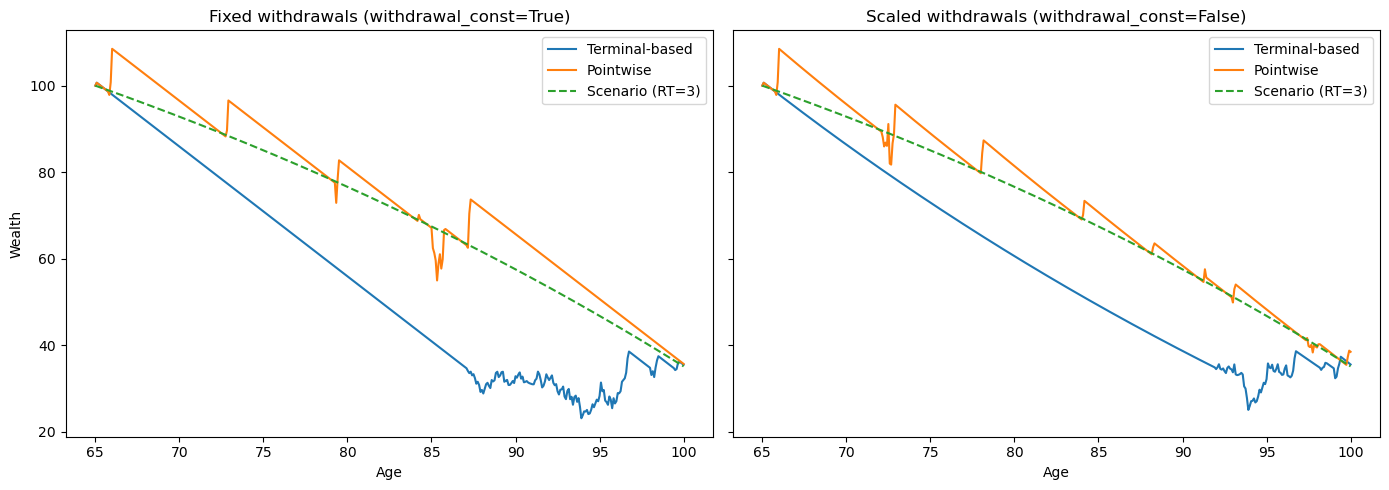

In [53]:
# Compare both withdrawal modes for both controllers:
# - Terminal-based vs Pointwise
# - Each with withdrawal_const=True (fixed amount) and withdrawal_const=False (scaled by Scenario ratio)
#
# Outputs:
#   CSVs for all 4 runs and a 2-panel comparison plot.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, log, sqrt

# ---------- Environment (rebuild if needed) ----------
if 'weights' not in globals() or 'df_returns' not in globals():
    mu_assets = {
        "asset0": 1.43*1e-02, "asset1": 5.19*1e-02, "asset2": 3.46*1e-02,
        "asset3": 0.86*1e-02, "asset4": 5.95*1e-02, "asset5": 2.67*1e-02,
        "asset6": 5.84*1e-02, "asset7": 7.28*1e-02, "asset8": 0,
    }
    sig_assets = {
        "asset0": np.sqrt(2.36*1e-02), "asset1": np.sqrt(14.60*1e-02), "asset2": np.sqrt(7.48*1e-02),
        "asset3": np.sqrt(4.75*1e-02), "asset4": np.sqrt(17.13*1e-02), "asset5": np.sqrt(14.45*1e-02),
        "asset6": np.sqrt(14.46*1e-02), "asset7": np.sqrt(18.99*1e-02), "asset8": 0,
    }
    weights = pd.DataFrame()
    weights["RT"] = np.arange(0, 10, 1)
    weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
    weights["E[r]"] = [0, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
    weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
    weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
    weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
    weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
    weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
    weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
    weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
    weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
    weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

    def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", seed=123):
        rng = np.random.default_rng(seed)
        assets = list(mu_dict.keys())
        n = len(assets)
        P = 12
        mu_p = np.array([mu_dict[a] / P for a in assets])
        sig_p = np.array([sig_dict[a] / np.sqrt(P) for a in assets])
        D = np.diag(sig_p)
        cov = D @ np.eye(n) @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
        idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
        return pd.DataFrame(rets, index=idx, columns=assets)
    df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", seed=123)

class FixedPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12
    def get_scenario(self, rt, init_val, contri, withdr):
        expect_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(expect_ret)
        val += contri
        val -= withdr
        return val

# ---- Helpers ----

def z_T(mu, sigma, t_years, W0, WT):
    if sigma <= 0:
        req_mu = (log(WT/W0)/t_years) if (W0>0 and WT>0 and t_years>0) else -np.inf
        return float('inf') if mu >= req_mu else float('-inf')
    return (((mu - 0.5*sigma**2) * sqrt(t_years)) - (log(WT / W0) / sqrt(t_years))) / sigma

def z_1(mu, sigma, dt_years, W0, W_target_1):
    if sigma <= 0:
        req = (log(W_target_1/W0)/dt_years) if (W0>0 and W_target_1>0 and dt_years>0) else -np.inf
        return float('inf') if mu >= req else float('-inf')
    return (((mu - 0.5*sigma**2) * sqrt(dt_years)) - (log(W_target_1 / W0) / sqrt(dt_years))) / sigma

def E_next_const(base, rt, W0, contrib, withdr):
    # one-step deterministic under fixed withdrawal
    A = exp((base.mu[rt] - 0.5*(base.sigma[rt]**2)) * base.dt)
    pre = W0 * A + contrib
    wd = withdr
    wd = min(wd, pre)
    return pre - wd, wd

def E_next_scaled(base, rt, W0, contrib, withdr, S_scn_t, cap_like=True):
    A = exp((base.mu[rt] - 0.5*(base.sigma[rt]**2)) * base.dt)
    pre = W0 * A + contrib
    k_t = withdr / max(S_scn_t, 1e-9)
    wd = k_t * W0
    if cap_like: wd = min(wd, pre)
    return pre - wd, wd

def E_terminal_const(base, rt, W0, steps_left, contrib, withdr):
    # closed form for fixed withdrawal (approx, without per-step cap)
    A = exp((base.mu[rt] - 0.5*(base.sigma[rt]**2)) * base.dt)
    C = (contrib - withdr)
    if abs(A - 1.0) < 1e-12:
        V = W0 + steps_left * C
    else:
        A_n = A**steps_left
        V = W0 * A_n + C * (A_n - 1.0)/(A - 1.0)
    cum_w = steps_left * withdr
    return V, cum_w

def E_terminal_scaled(base, rt, W0, steps_left, contrib, withdr, scenario_prefix, cap_like=True):
    V = W0; cum_w = 0.0
    A = exp((base.mu[rt] - 0.5*(base.sigma[rt]**2)) * base.dt)
    for k in range(steps_left):
        S_scn_prev = scenario_prefix[k]
        k_t = withdr / max(S_scn_prev, 1e-9)
        pre = V*A + contrib
        wd = k_t * V
        if cap_like: wd = min(wd, pre)
        V = pre - wd
        cum_w += wd
    return V, cum_w

# ---- Choosers ----
def choose_rt_terminal(weights_df, base, const_flag, t_years, steps_left, W0,
                       scenario_T, scenario_rem_cum_wd, scenario_prefix, contrib, withdr,
                       alpha=1.0, beta=1.0, cap_like=True):
    mu = weights_df["E[r]"].to_numpy()
    sigma = weights_df["Vol"].to_numpy()
    denom = max(scenario_T + scenario_rem_cum_wd, 1e-9)
    best_score, best_rt = -1e308, 0
    for rt in range(len(weights_df)):
        z = z_T(mu[rt], sigma[rt], t_years, W0, scenario_T)
        if const_flag:
            V, cum_w = E_terminal_const(base, rt, W0, steps_left, contrib, withdr)
        else:
            V, cum_w = E_terminal_scaled(base, rt, W0, steps_left, contrib, withdr, scenario_prefix, cap_like)
        total_rt = V + cum_w
        total_scn = scenario_T + scenario_rem_cum_wd
        dev_down = max(total_scn - total_rt, 0.0) / denom
        score = alpha * z - beta * dev_down
        if score > best_score:
            best_score, best_rt = score, rt
    return best_rt

def choose_rt_pointwise(weights_df, base, const_flag, dt_years, W0, S_scn_t, S_scn_next,
                        contrib, withdr, alpha=1.0, beta=1.0, cap_like=True):
    mu = weights_df["E[r]"].to_numpy()
    sigma = weights_df["Vol"].to_numpy()
    denom = max(S_scn_next + withdr, 1e-9)
    best_score, best_rt = -1e308, 0
    for rt in range(len(weights_df)):
        z = z_1(mu[rt], sigma[rt], dt_years, W0, S_scn_next)
        if const_flag:
            E_W1, w1 = E_next_const(base, rt, W0, contrib, withdr)
        else:
            E_W1, w1 = E_next_scaled(base, rt, W0, contrib, withdr, S_scn_t, cap_like)
        total_rt_1 = E_W1 + w1
        total_scn_1 = S_scn_next + withdr
        dev_down = max(total_scn_1 - total_rt_1, 0.0) / denom
        score = alpha * z - beta * dev_down
        if score > best_score:
            best_score, best_rt = score, rt
    return best_rt

# ---- Runners ----
def run_controller(rets, weights_df, init_rt, init_val, contribution, withdrawal,
                   const_flag, terminal_based, init_age, terminal_age, cap_like=True,
                   alpha=1.0, beta=1.0):
    base = FixedPortfolio(weights_df)
    n = rets.shape[0] + 1
    m = weights_df.shape[1] - 3
    # Scenario with baseline RT=init_rt (only for reference / scaling / target path)
    scenario = np.zeros(n); scenario[0] = init_val
    for t in range(1, n):
        scenario[t] = base.get_scenario(init_rt, scenario[t-1], contribution, withdrawal)
    scenario_T = float(scenario[-1])

    S = np.zeros(n); S[0] = init_val
    x = np.zeros((n, m)); x[0] = base.weights[init_rt] * (init_val + contribution)
    RTs = np.zeros(n, dtype=int); RTs[0] = init_rt
    ages = init_age + np.arange(n)/12.0
    dt_years = 1/12.0

    for t in range(1, n):
        pre = np.dot(1.0 + rets[t-1], x[t-1]) + contribution
        # Select RT first (policy based on state before withdrawal)
        if terminal_based:
            t_years = max(terminal_age - ages[t-1], 1e-6)
            steps_left = n - t
            scen_idx_prev = max(0, t-1)
            scenario_prefix = scenario[scen_idx_prev:scen_idx_prev+steps_left]
            scenario_rem_cum_wd = steps_left * withdrawal
            rt = choose_rt_terminal(weights_df, base, const_flag, t_years, steps_left, S[t-1],
                                    scenario_T, scenario_rem_cum_wd, scenario_prefix,
                                    contribution, withdrawal, alpha=alpha, beta=beta, cap_like=cap_like)
        else:
            scen_idx_prev = t-1
            S_scn_t = scenario[scen_idx_prev]
            S_scn_next = scenario[scen_idx_prev+1]
            rt = choose_rt_pointwise(weights_df, base, const_flag, dt_years, S[t-1], S_scn_t, S_scn_next,
                                     contribution, withdrawal, alpha=alpha, beta=beta, cap_like=cap_like)

        RTs[t] = rt
        # Realized withdrawal
        if const_flag:
            wd = min(withdrawal, pre)
        else:
            ratio = S[t-1] / max(scenario[scen_idx_prev], 1e-9)
            wd = min(withdrawal * ratio, pre)
        S[t] = pre - wd
        x[t] = S[t] * base.weights[rt]
    return S, RTs, scenario

# ---- Parameters & run ----
INIT_RT = 1
INIT_VAL = 100.0
WITHDRAWAL = 0.03/12 * INIT_VAL
CONTRIB = 0.0
INIT_AGE = 65.0
TERM_AGE = 100.0
N_STEPS = 12*35

rets = df_returns.sample(N_STEPS, replace=True).values

# 4 runs
S_term_const, RTs_term_const, scenario_path = run_controller(
    rets, weights, INIT_RT, INIT_VAL, CONTRIB, WITHDRAWAL,
    const_flag=True,  terminal_based=True,  init_age=INIT_AGE, terminal_age=TERM_AGE, cap_like=True)

S_point_const, RTs_point_const, _ = run_controller(
    rets, weights, INIT_RT, INIT_VAL, CONTRIB, WITHDRAWAL,
    const_flag=True,  terminal_based=False, init_age=INIT_AGE, terminal_age=TERM_AGE, cap_like=True)

S_term_scaled, RTs_term_scaled, _ = run_controller(
    rets, weights, INIT_RT, INIT_VAL, CONTRIB, WITHDRAWAL,
    const_flag=False, terminal_based=True,  init_age=INIT_AGE, terminal_age=TERM_AGE, cap_like=True)

S_point_scaled, RTs_point_scaled, _ = run_controller(
    rets, weights, INIT_RT, INIT_VAL, CONTRIB, WITHDRAWAL,
    const_flag=False, terminal_based=False, init_age=INIT_AGE, terminal_age=TERM_AGE, cap_like=True)

# Save CSVs
def save_run(path, S, RTs):
    df = pd.DataFrame({"age": INIT_AGE + np.arange(len(S))/12, "wealth": S, "RT": RTs})
    df.to_csv(path, index=False)

#p_term_const   = "/mnt/data/run_terminal_const.csv"
#p_point_const  = "/mnt/data/run_pointwise_const.csv"
#p_term_scaled  = "/mnt/data/run_terminal_scaled.csv"
#p_point_scaled = "/mnt/data/run_pointwise_scaled.csv"

#save_run(p_term_const,   S_term_const,   RTs_term_const)
#save_run(p_point_const,  S_point_const,  RTs_point_const)
#save_run(p_term_scaled,  S_term_scaled,  RTs_term_scaled)
#save_run(p_point_scaled, S_point_scaled, RTs_point_scaled)

# Plot: two panels (const vs scaled), each showing terminal vs pointwise
AGE = INIT_AGE + np.arange(len(S_term_const))/12
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

axes[0].plot(AGE, S_term_const,  label="Terminal-based")
axes[0].plot(AGE, S_point_const, label="Pointwise")
axes[0].plot(AGE, scenario_path, label="Scenario (RT=3)", linestyle="--")
axes[0].set_title("Fixed withdrawals (withdrawal_const=True)")
axes[0].set_xlabel("Age"); axes[0].set_ylabel("Wealth"); axes[0].legend()

axes[1].plot(AGE, S_term_scaled,  label="Terminal-based")
axes[1].plot(AGE, S_point_scaled, label="Pointwise")
axes[1].plot(AGE, scenario_path,  label="Scenario (RT=3)", linestyle="--")
axes[1].set_title("Scaled withdrawals (withdrawal_const=False)")
axes[1].set_xlabel("Age"); axes[1].legend()

plt.tight_layout()
#plot_path = "/mnt/data/compare_const_vs_scaled_terminal_vs_pointwise.png"
plt.show()

#(p_term_const, p_point_const, p_term_scaled, p_point_scaled, plot_path)
